<a href="https://colab.research.google.com/github/bonly/AI/blob/main/train_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 描述
使用akshare获取A股sh600048的历史股票数据，并使用pytorch实现价格预测。

## 数据获取

### 使用akshare获取A股sh600048的历史股票数据。


In [ ]:
%pip install akshare

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 100.2 MB/s eta 0:00:00
  Created wheel for jsonpath: filename=jsonpath-0.82.2-py3-none-any.whl size=5615 sha256=8fc9e8a95cec9c58115db91b2f82209bc002e643fa05d37f9cee86655720e574
  Stored in directory: /root/.cache/pip/wheels/7d/b8/16/48bbd715040679311fa68cb564ad24a97d9a67fea5d4c848c8
Successfully built jsonpath


安装akshare包



In [ ]:
import akshare as ak
import pandas as pd

start_date = "20240101"
end_date = "20250815"

# df = ak.stock_zh_a_hist(symbol="sh600048", period="daily", start_date=start_date, end_date=end_date, adjust="qfq")
df = ak.stock_zh_a_daily(symbol="sh600048", start_date=start_date, end_date=end_date, adjust="qfq")

display(df.head())
display(df.info())

,date,open,high,low,close,volume,amount,outstanding_share,turnover
0,2024-01-02,9.38,9.41,8.97,8.98,117278568.0,1.120367e+09,1.197044e+10,0.009797
1,2024-01-03,8.96,9.13,8.88,8.96,89972552.0,8.494157e+08,1.197044e+10,0.007516
2,2024-01-04,8.94,8.96,8.62,8.72,105095748.0,9.624206e+08,1.197044e+10,0.008780
3,2024-01-05,8.69,8.93,8.63,8.74,101885181.0,9.398792e+08,1.197044e+10,0.008511
4,2024-01-08,8.74,8.80,8.61,8.63,67455132.0,6.155500e+08,1.197044e+10,0.005635


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               393 non-null    object 
 1   open               393 non-null    float64
 2   high               393 non-null    float64
 3   low                393 non-null    float64
 4   close              393 non-null    float64
 5   volume             393 non-null    float64
 6   amount             393 non-null    float64
 7   outstanding_share  393 non-null    float64
 8   turnover           393 non-null    float64
dtypes: float64(8), object(1)
memory usage: 27.8+ KB


None

## 数据清洗


日期处理、特征选择和使用 PyTorch 进行标准化。

In [ ]:
import torch
import numpy as np

# 将 'date' 列转换为日期时间格式并设置为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 选择用于预测的特征，例如 'open', 'close', 'high', 'low', 'volume'
features = ['open', 'close', 'high', 'low', 'volume']
data = df[features].values

# 将 numpy 数组转换为 PyTorch 张量
data_tensor = torch.tensor(data, dtype=torch.float32)

# 使用 PyTorch 进行标准化处理 (MinMaxScaler 的 PyTorch 实现)
# 计算最小值和最大值
min_vals = torch.min(data_tensor, dim=0)[0]
max_vals = torch.max(data_tensor, dim=0)[0]

# 应用标准化公式: (x - min) / (max - min)
scaled_data = (data_tensor - min_vals) / (max_vals - min_vals)


# 打印处理后的数据形状和前几行
print("标准化后的数据形状:", scaled_data.shape)
print("\n标准化后的数据前5行:")
print(scaled_data[:5])

标准化后的数据形状: torch.Size([393, 5])

标准化后的数据前5行:
tensor([[0.4161, 0.3643, 0.4048, 0.4395, 0.1352],
        [0.3270, 0.3595, 0.3435, 0.4158, 0.0937],
        [0.3227, 0.3024, 0.3063, 0.3474, 0.1167],
        [0.2696, 0.3071, 0.2998, 0.3500, 0.1118],
        [0.2803, 0.2810, 0.2713, 0.3447, 0.0595]])


* dim=0

  * 维度上计算最小值。
  * 解释：

    * dim=0 表示在第一个维度（即列方向）上计算最小值。
    * 如果 data_tensor 是二维的，比如：
      ```
      [[1, 5, 3],
      [2, 4, 6]]
      ```
    那么 torch.min(data_tensor, dim=0) 会在每一列上找最小值，结果是 [1, 4, 3]。






* [0]

    * 含义：torch.min() 返回两个值：最小值和最小值的索引。[0] 表示只取最小值，不取索引。
    * 举例：
    如果 torch.min(data_tensor, dim=0) 返回 (tensor([1, 4, 3]), tensor([0, 1, 0]))，那么 [0] 就只取 tensor([1, 4, 3])。

代码的作用是：在 data_tensor 的第 0 维（即每一列）上找最小值，并把结果存储在 min_vals 中。

如果 data_tensor 是一维的，比如 [1, 3, 2, 5, 4]，那么 min_vals 就是 1。
如果 data_tensor 是二维的，比如上面的例子，那么 min_vals 就是 [1, 4, 3]。

## 创建用于 LSTM 模型训练的时间序列数据

In [ ]:
# 创建序列数据
def create_sequences(data, seq_length):
    """
    创建时间序列的输入和输出序列。

    Args:
        data (torch.Tensor): 标准化后的数据张量。
        seq_length (int): 输入序列的长度（look-back window）。

    Returns:
        tuple: 包含输入序列和输出序列的张量。
    """
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]  # 预测下一个交易日的开盘价
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

# 设置序列长度 (可以根据需要调整)
seq_length = 60

# 创建训练数据和标签
X, y = create_sequences(scaled_data, seq_length)

# 打印序列数据形状
print("输入序列形状:", X.shape)
print("输出序列形状:", y.shape)

输入序列形状: torch.Size([333, 60, 5])
输出序列形状: torch.Size([333])


### 2/8拆分训练和检验数据

In [ ]:
# 划分训练集和测试集
train_size = int(len(X) * 0.8)  # 80% 的数据用于训练
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 打印训练集和测试集的形状
print("训练集输入形状:", X_train.shape)
print("训练集输出形状:", y_train.shape)
print("测试集输入形状:", X_test.shape)
print("测试集输出形状:", y_test.shape)

训练集输入形状: torch.Size([266, 60, 5])
训练集输出形状: torch.Size([266])
测试集输入形状: torch.Size([67, 60, 5])
测试集输出形状: torch.Size([67])


## 构建PyTorch LSTM 模型

In [ ]:
import torch.nn as nn

# 定义 LSTM 模型
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        # batch_first=True 表示输入和输出张量的第一个维度是批次大小
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        # hidden_cell 的形状应该是 (num_layers, batch_size, hidden_size)
        # 在这里，num_layers=1
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        # input_seq 的形状是 (batch_size, seq_length, input_size)
        # 如果 batch_first=True, LSTM 期望的输入形状就是这样
        # lstm_out 的形状将是 (batch_size, seq_length, hidden_size)
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        # 我们只关心序列的最后一个时间步的输出
        # lstm_out[:, -1, :] 的形状是 (batch_size, hidden_size)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions # 返回所有批次的预测结果

# 设置模型参数
input_size = len(features)  # 输入特征的数量
hidden_layer_size = 100     # LSTM隐藏层大小
output_size = 1             # 预测输出大小 (开盘价)

# 实例化模型
model = StockPredictor(input_size, hidden_layer_size, output_size)

print("模型构建完成:")
print(model)

模型构建完成:
StockPredictor(
  (lstm): LSTM(5, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


## 使用训练数据对模型进行了训练

In [ ]:
import torch.optim as optim

# 定义损失函数和优化器
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 设置训练参数
epochs = 100  # 训练轮数

# 将模型设置为训练模式
model.train()

# 训练模型
print("开始训练模型...")
for i in range(epochs):
    # 清除之前的梯度
    optimizer.zero_grad()

    # 初始化隐藏状态，批量大小与输入数据匹配
    # X_train 的形状是 (batch_size, seq_length, input_size)
    batch_size = X_train.size(0)
    model.hidden_cell = (torch.zeros(1, batch_size, model.hidden_layer_size),
                        torch.zeros(1, batch_size, model.hidden_layer_size))


    # 进行前向传播
    y_pred = model(X_train)

    # 计算损失
    # y_pred 的形状是 (batch_size, output_size)，y_train 的形状是 (batch_size)
    # 使用 squeeze() 移除 y_pred 的最后一个维度以匹配 y_train 的形状
    single_loss = loss_function(y_pred.squeeze(), y_train)


    # 进行反向传播和优化
    single_loss.backward()
    optimizer.step()

    # 打印训练信息
    if i % 10 == 1:
        print(f'Epoch: {i:3} Loss: {single_loss.item():10.8f}')

print("模型训练完成。")

开始训练模型...
Epoch:   1 Loss: 0.08230337
Epoch:  11 Loss: 0.02764009
Epoch:  21 Loss: 0.01588702
Epoch:  31 Loss: 0.00834400
Epoch:  41 Loss: 0.00622443
Epoch:  51 Loss: 0.00547860
Epoch:  61 Loss: 0.00485725
Epoch:  71 Loss: 0.00456269
Epoch:  81 Loss: 0.00431353
Epoch:  91 Loss: 0.00410604
模型训练完成。


## 在测试集上评估了模型的性能，并进行了股票开盘价的预测。

In [ ]:
# 将模型设置为评估模式
model.eval()

# 使用 torch.no_grad() 禁用梯度计算，以加速评估
with torch.no_grad():
    # 初始化隐藏状态，批量大小与测试数据匹配
    # X_test 的形状是 (batch_size, seq_length, input_size)
    batch_size_test = X_test.size(0)
    model.hidden_cell = (torch.zeros(1, batch_size_test, model.hidden_layer_size),
                        torch.zeros(1, batch_size_test, model.hidden_layer_size))

    # 在测试集上进行预测
    y_test_pred = model(X_test)

    # 计算测试集上的损失 (可选)
    test_loss = loss_function(y_test_pred.squeeze(), y_test)
    print(f"测试集上的损失: {test_loss.item():10.8f}")

# 由于预测结果是标准化的，我们需要将其反标准化回原始比例
# 注意：这里的反标准化需要使用原始数据的 min_vals 和 max_vals
# 我们需要确保这些值在测试阶段仍然可用。
# 为了简化，我们假设 min_vals 和 max_vals 已经被保存或者可以重新计算 (虽然重新计算不严谨)
# 在实际应用中，您应该保存训练时使用的 scaler 或 min/max 值
# 这里为了演示，我们使用之前计算的 min_vals 和 max_vals
# 预测的是开盘价，对应features列表中的第一个特征
predicted_opens_scaled = y_test_pred.squeeze()
# 获取开盘价特征的最小值和最大值
open_min = min_vals[0]
open_max = max_vals[0]

# 反标准化预测的开盘价
predicted_opens = predicted_opens_scaled * (open_max - open_min) + open_min

# 将实际测试集的开盘价也反标准化，以便进行比较
actual_opens_scaled = y_test
actual_opens = actual_opens_scaled * (open_max - open_min) + open_min


# 打印预测结果和实际结果的前几项
print("\n预测的开盘价 (前5项):")
print(predicted_opens[:5])
print("\n实际的开盘价 (前5项):")
print(actual_opens[:5])

测试集上的损失: 0.00061652

预测的开盘价 (前5项):
tensor([8.3182, 8.3165, 8.2956, 8.2751, 8.2599])

实际的开盘价 (前5项):
tensor([8.2900, 8.3100, 8.2600, 8.2600, 8.2800])


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas

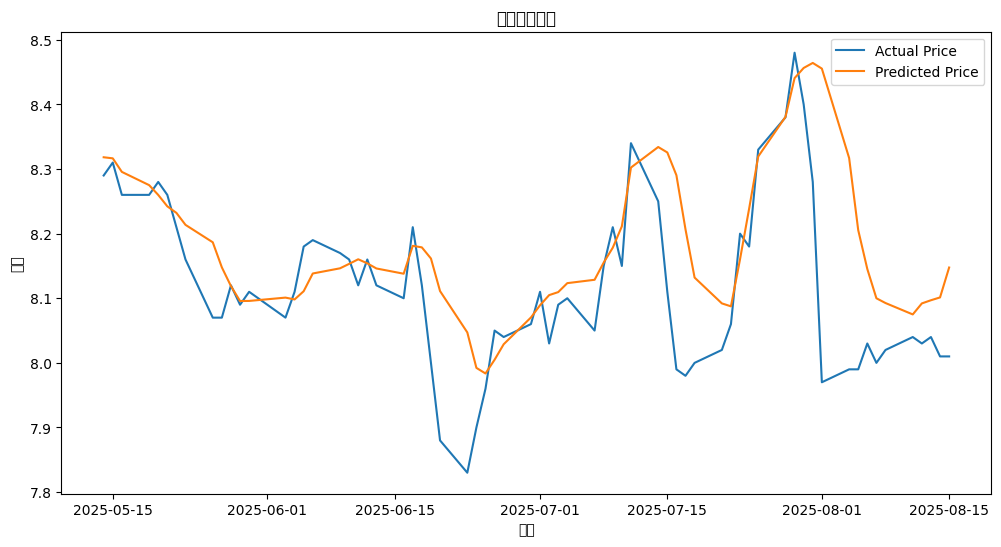

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 配置matplotlib支持中文
font_prop = fm.FontProperties(fname="/root/.fonts/wqy-zenhei.ttc")
# mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
mpl.rcParams['font.sans-serif'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 创建一个包含实际价格和预测价格的 DataFrame
# 为了正确对齐，我们需要测试集的日期索引
# 测试集的日期对应于原始df中从 train_size + seq_length 开始的日期
test_dates = df.index[train_size + seq_length:]

results_df = pd.DataFrame({'Actual': actual_opens.numpy(), 'Predicted': predicted_opens.numpy()}, index=test_dates)

# 绘制实际价格和预测价格的折线图
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Price')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Price')
plt.title('股票价格预测')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.show()

## 中文显示问题

In [ ]:
# 安装wqy-zenhei字体
!apt-get update
!apt-get install -y fonts-wqy-zenhei

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,271 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main 

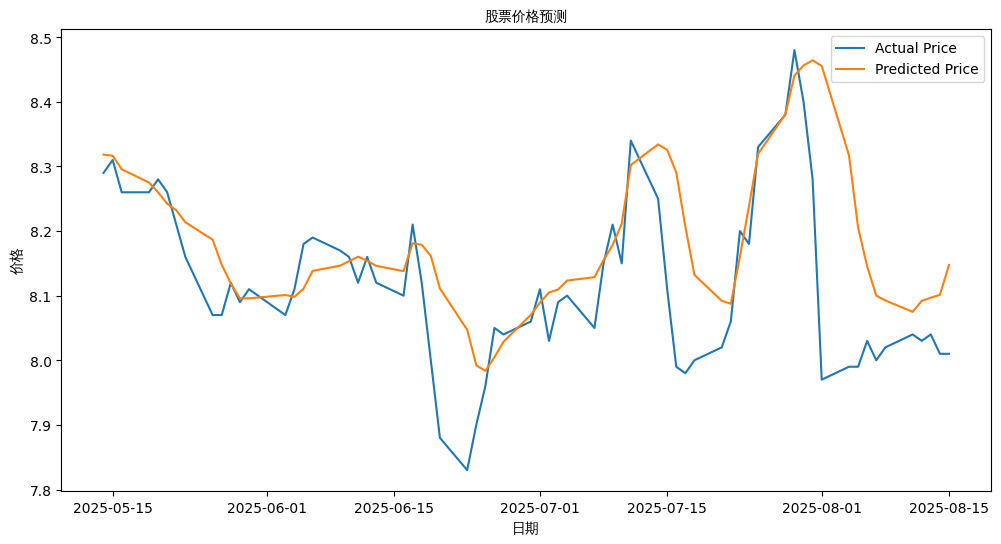

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm

# 删除字体缓存文件 (如果存在)
cache_dir = mpl.get_cachedir()
# 查找所有可能的fontlist.json文件版本
cache_files = [f for f in os.listdir(cache_dir) if f.startswith('fontlist-v') and f.endswith('.json')]
for cache_file in cache_files:
    cache_path = os.path.join(cache_dir, cache_file)
    try:
        os.remove(cache_path)
        print(f"Removed font cache file: {cache_path}")
    except OSError as e:
        print(f"Error removing file {cache_path}: {e}")


# 指定中文字体文件路径
#chinese_font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'
chinese_font_path = '/root/.fonts/wqy-zenhei.ttc'

# 创建字体属性
font_prop = fm.FontProperties(fname=chinese_font_path)

# 配置matplotlib使用指定字体
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 创建一个包含实际价格和预测价格的 DataFrame
# 为了正确对齐，我们需要测试集的日期索引
# 测试集的日期对应于原始df中从 train_size + seq_length 开始的日期
test_dates = df.index[train_size + seq_length:]

results_df = pd.DataFrame({'Actual': actual_opens.numpy(), 'Predicted': predicted_opens.numpy()}, index=test_dates)

# 绘制实际价格和预测价格的折线图
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Price')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Price')
plt.title('股票价格预测', fontproperties=font_prop) # 在需要显示中文的地方指定字体属性
plt.xlabel('日期', fontproperties=font_prop)
plt.ylabel('价格', fontproperties=font_prop)
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas

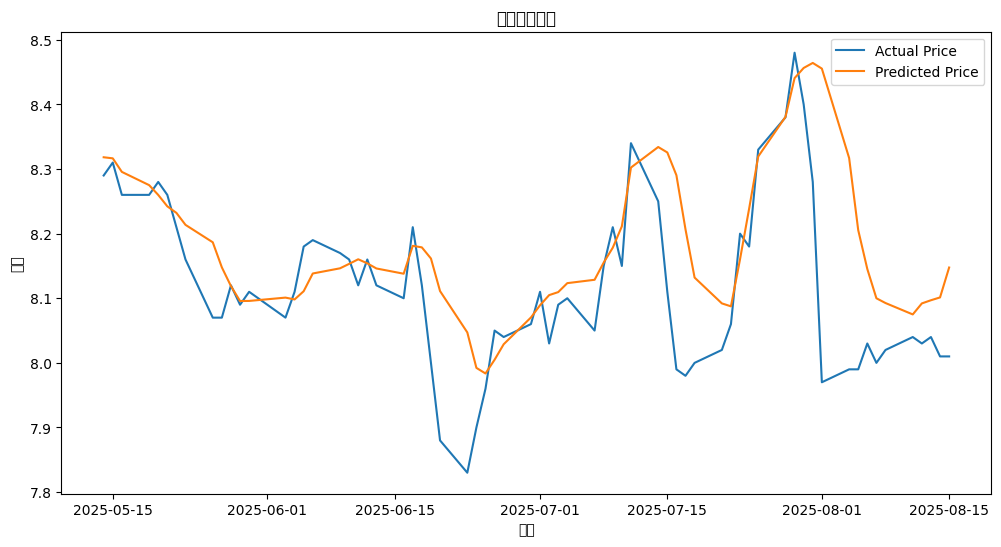

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm

# 删除字体缓存文件 (如果存在)
cache_dir = mpl.get_cachedir()
# 查找所有可能的fontlist.json文件版本
cache_files = [f for f in os.listdir(cache_dir) if f.startswith('fontlist-v') and f.endswith('.json')]
for cache_file in cache_files:
    cache_path = os.path.join(cache_dir, cache_file)
    try:
        os.remove(cache_path)
        print(f"Removed font cache file: {cache_path}")
    except OSError as e:
        print(f"Error removing file {cache_path}: {e}")


# 指定中文字体文件路径
#chinese_font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'
chinese_font_path = '/root/.fonts/wqy-zenhei.ttc'

# 创建字体属性
font_prop = fm.FontProperties(fname=chinese_font_path)

# 尝试设置全局字体
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题


# 创建一个包含实际价格和预测价格的 DataFrame
# 为了正确对齐，我们需要测试集的日期索引
# 测试集的日期对应于原始df中从 train_size + seq_length 开始的日期
test_dates = df.index[train_size + seq_length:]

results_df = pd.DataFrame({'Actual': actual_opens.numpy(), 'Predicted': predicted_opens.numpy()}, index=test_dates)

# 绘制实际价格和预测价格的折线图
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Price')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Price')
plt.title('股票价格预测') # 直接使用字符串，因为全局字体已设置
plt.xlabel('日期')      # 直接使用字符串，因为全局字体已设置
plt.ylabel('价格')      # 直接使用字符串，因为全局字体已设置
plt.legend()
plt.show()

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 查找所有可用的中文字体
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

chinese_fonts = [f for f in font_list if 'wqy' in f.lower() or 'ukai' in f.lower() or 'gkai' in f.lower() or 'simhei' in f.lower()]

print("Available Chinese fonts:")
for f in chinese_fonts:
    print(f)

# 尝试使用找到的字体名称进行配置
# 注意：您可能需要根据上面的输出选择一个合适的字体名称
# 例如，如果输出中有 '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttf'，
# 字体名称可能是 'WenQuanYi Zen Hei' 或 'wqy-zenhei'

# 假设我们找到了 'WenQuanYi Zen Hei' 这个名字，您可以尝试取消下面两行的注释
# mpl.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
# mpl.rcParams['axes.unicode_minus'] = False

# 然后重新运行绘图代码
# plt.figure(figsize=(12, 6))
# plt.plot(results_df.index, results_df['Actual'], label='Actual Price')
# plt.plot(results_df.index, results_df['Predicted'], label='Predicted Price')
# plt.title('股票价格预测')
# plt.xlabel('日期')
# plt.ylabel('价格')
# plt.legend()
# plt.show()

Available Chinese fonts:
/root/.fonts/wqy-zenhei.ttc


## LSTM模型

**LSTM（Long Short-Term Memory，长短时记忆网络）** 是一种特殊的**循环神经网络（RNN）**架构，专门设计用于解决传统 RNN 在处理长序列数据时的**梯度消失或爆炸**问题。LSTM 通过引入**记忆单元（Memory Cell）**和**门控机制（Gating Mechanism）**，能够更有效地捕捉和保留序列数据中的长期依赖关系。

---

### **LSTM 的核心概念**
1. **记忆单元（Memory Cell）**
   - 类似于一个“信息高速公路”，可以在长时间内保存或传递信息。
   - 通过门控机制决定何时读取、写入或清除信息。

2. **门控机制（Gates）**
   LSTM 有三个主要的门：
   - **遗忘门（Forget Gate）**：决定是否遗忘上一时刻的记忆单元信息（0 = 完全遗忘，1 = 完全保留）。
   - **输入门（Input Gate）**：决定是否将新的信息写入记忆单元。
   - **输出门（Output Gate）**：决定是否将记忆单元的信息输出到当前时刻的隐藏状态。

3. **隐藏状态（Hidden State）**
   - 类似于传统 RNN 的隐藏层，但 LSTM 的隐藏状态同时包含**短期记忆**（当前时刻的输出）和**长期记忆**（记忆单元的状态）。

---

### **LSTM 的优势**
- **解决长期依赖问题**：通过门控机制，LSTM 能够选择性地保留或遗忘信息，从而在处理长序列（如文本、时间序列）时表现更佳。
- **避免梯度消失/爆炸**：门控机制使得梯度能够在长时间内稳定传播，提高了训练的稳定性。
- **广泛应用**：在机器翻译、语音识别、时间序列预测、自然语言处理等领域取得了显著成果。

---

### **LSTM 的应用场景**
- **自然语言处理（NLP）**：机器翻译、文本生成、情感分析。
- **时间序列分析**：股票价格预测、天气预报、能源消耗预测。
- **语音识别**：将语音信号转换为文本。
- **视频分析**：动作识别、帧间依赖建模。

---

### **LSTM 与传统 RNN 的对比**
| 特性         | 传统 RNN          | LSTM                  |
|--------------|-------------------|-----------------------|
| 记忆能力     | 短期记忆          | 长期 + 短期记忆       |
| 梯度问题     | 易消失/爆炸       | 通过门控机制缓解     |
| 应用范围     | 短序列            | 长序列、复杂依赖     |

---

### **LSTM 的变体**
- **GRU（Gated Recurrent Unit）**：简化版的 LSTM，只有更新门和重置门，计算效率更高。
- **双向 LSTM（BiLSTM）**：同时利用过去和未来的信息，提高上下文理解能力。
- **堆叠 LSTM（Stacked LSTM）**：多层 LSTM 叠加，增强模型表达能力。

---

### **总结**
LSTM 是深度学习中处理序列数据的“黄金标准”之一，尤其在需要捕捉长期依赖关系的任务中表现出色。虽然近年来 Transformer 模型（如 BERT、GPT）在某些领域超越了 LSTM，但 LSTM 仍然是理解序列建模的基础，并在许多实际应用中发挥着重要作用。

---


### **LSTM 的原理：用“记忆笔记本”来类比**

想象你正在阅读一本**长篇小说**，一边读一边做笔记。为了理解整个故事，你需要：
- **记住关键情节**（比如主人公的动机、重要的转折点），
- **遗忘无关细节**（比如某个路人的衣着描述），
- **根据新信息更新笔记**（比如新的人物关系或剧情反转）。

**LSTM 就是一个“智能笔记本”**，它通过**三个门控**（遗忘门、输入门、输出门）和**记忆单元**，自动完成上述过程。

---

## **1. LSTM 的“笔记本”结构**
每个 LSTM 单元（Cell）类似于一个**带锁的笔记本页**，包含：
- **记忆单元（Cell State, Cₜ）**：存储长期信息（比如“主人公想复仇”）。
- **隐藏状态（Hidden State, hₜ）**：当前时刻的“笔记摘要”（比如“主人公遇到了帮手”）。

![LSTM 单元示意](https://miro.medium.com/max/1400/1*33mTpXqMZ2DYvX1gZ8Z2xA.png)
*（图中展示了信息如何通过门控流动）*

---

## **2. 三个“门控”的作用（用小说阅读类比）**

### **① 遗忘门（Forget Gate）**
**问题**：上一页的笔记（Cₜ₋₁）中，哪些内容**不再重要**？
**操作**：
- 根据**当前输入**（新读到的句子，xₜ）和**上一时刻的摘要**（hₜ₋₁），
- 计算一个**0到1的权重**（fₜ），决定**遗忘多少旧信息**。
  - 0 = 完全遗忘（比如“路人的衣着”）
  - 1 = 完全保留（比如“主人公的目标”）

**公式**：
fₜ = σ(W_f · [hₜ₋₁, xₜ] + b_f)
*σ 是 Sigmoid 函数，输出 0~1 的权重。*

---

### **② 输入门（Input Gate）**
**问题**：当前句子（xₜ）中，**哪些信息值得记录**到笔记本？
**操作**：
1. **决定是否记录**：计算一个**输入权重**（iₜ，0~1）。
2. **生成候选记录**：用 tanh 生成一个**新的候选值**（C̃ₜ，可以是正负值）。
3. **更新记忆单元**：将候选值按 iₜ 的权重**加入笔记本**。

**公式**：
iₜ = σ(W_i · [hₜ₋₁, xₜ] + b_i)  // 决定记录多少
C̃ₜ = tanh(W_C · [hₜ₋₁, xₜ] + b_C)  // 候选记录
**Cₜ = fₜ * Cₜ₋₁ + iₜ * C̃ₜ**  // 更新后的笔记本

**例子**：
- 如果新句子是“主人公找到了失传的宝剑”，
  - iₜ 可能接近 1（很重要！），
  - C̃ₜ 会编码“宝剑=关键道具”，
  - Cₜ 更新为“主人公目标：复仇 + 宝剑”。

---

### **③ 输出门（Output Gate）**
**问题**：根据**更新后的笔记本**（Cₜ），输出**当前时刻的摘要**（hₜ）给下一步。
**操作**：
1. 计算**输出权重**（oₜ，0~1）。
2. 将记忆单元（Cₜ）通过 tanh 压缩到 -1~1，
3. 按 oₜ 权重**选择性输出**。

**公式**：
oₜ = σ(W_o · [hₜ₋₁, xₜ] + b_o)
hₜ = oₜ * tanh(Cₜ)  // 当前时刻的“笔记摘要”

**例子**：
- 如果 Cₜ 包含“宝剑+复仇”，
  - hₜ 可能输出“主人公准备复仇”，
  - 传递给下一个 LSTM 单元。

---

## **3. 完整流程：阅读小说的 LSTM**
假设小说情节依次为：
1. “主人公家人被杀”（x₁）
2. “主人公发誓复仇”（x₂）
3. “主人公遇到武功高手”（x₃）
4. “主人公得到宝剑”（x₄）

| 时刻 | 输入（xₜ）          | 遗忘门（fₜ）       | 输入门（iₜ + C̃ₜ）       | 记忆单元（Cₜ）更新          | 输出（hₜ）摘要          |
|------|---------------------|--------------------|--------------------------|-----------------------------|--------------------------|
| 1    | 家人被杀            | 遗忘一切（f₁=0）   | 记录“复仇动机”（i₁=1）   | C₁ = “复仇”                 | h₁ = “主人公想复仇”      |
| 2    | 发誓复仇            | 保留“复仇”（f₂=1）  | 强化“复仇”（i₂=1）        | C₂ = “复仇+誓言”            | h₂ = “复仇决心更强”      |
| 3    | 遇到武功高手         | 保留“复仇”（f₃=1）  | 加入“帮手”（i₃=0.8）      | C₃ = “复仇+帮手”            | h₃ = “有帮手助复仇”      |
| 4    | 得到宝剑            | 保留“复仇+帮手”（f₄=1） | 加入“宝剑”（i₄=0.9）  | C₄ = “复仇+帮手+宝剑”       | h₄ = “全副武装准备复仇”  |

---
### **关键洞察**
- **长期记忆**：通过 Cₜ 保留“复仇”主线，避免梯度消失。
- **选择性更新**：遗忘门和输入门让模型**聚焦关键信息**，忽略噪声。
- **动态输出**：输出门确保 hₜ 只包含**当前相关**的信息。

---

## **4. 为什么 LSTM 比 RNN 强？**
- **RNN 的问题**：
  - 如同用**同一支铅笔**不断擦写，旧信息很快被“抹掉”（梯度消失）。
  - 例子：读到第 100 页时，早已忘记第 1 页的“复仇动机”。

- **LSTM 的优势**：
  - 如同**带锁的笔记本**，可以**锁定重要信息**（Cₜ），**选择性更新**。
  - 例子：即使读到第 100 页，“复仇”主线依然清晰。

---

## **5. 现实中的类比**
- **写作**：
  - 遗忘门 = 删除无关草稿，
  - 输入门 = 添加新灵感，
  - 输出门 = 提炼段落大意。

- **人脑记忆**：
  - 遗忘门 = 忘记无用细节（比如昨天吃了什么），
  - 输入门 = 记住重要事件（比如朋友生日），
  - 输出门 = 回忆时提取关键信息。

---
### **总结**
LSTM 通过**门控机制**模拟了“选择性记忆”的过程，让机器能像人类一样：
- **记住关键**，**遗忘琐碎**，**动态更新**，
- 从而处理**超长序列**（如整本小说、长时间序列）而不混乱。



In [ ]:
# 列出字体目录下的文件
!ls -l /usr/share/fonts/truetype/wqy/

ls: cannot access '/usr/share/fonts/truetype/wqy/': No such file or directory


### LSTM比喻
如果把普通神经网络比作“一次性处理信息的计算器”，那么LSTM（长短期记忆网络）就是一个“带记事本的秘书”——它能在处理序列数据（比如句子、时间序列）时，有选择地记住重要信息、忘记无关细节，就像秘书在记录会议纪要时，会重点记下老板的决策，而忽略茶水间的闲聊。


### 用“秘书记会议纪要”理解LSTM的核心逻辑
假设你是秘书，正在记录一场持续2小时的会议，需要解决3个问题：
1. **哪些信息需要记下来？**（输入门）
2. **之前记的哪些内容可以删掉？**（遗忘门）
3. **现在需要向别人汇报什么？**（输出门）

LSTM的工作机制和这个过程几乎一模一样，它有三个“门”（本质是神经网络层）来控制信息的流动，还有一个“细胞状态”（类似记事本）来保存关键信息。


#### 1. 细胞状态（Cell State）：秘书的核心记事本
想象一本厚厚的笔记本，会议中所有重要信息都按顺序写在上面，这就是LSTM的“细胞状态”。它像一条传送带，信息在上面平稳流动，只有少量修改——这就是LSTM能记住长期依赖的关键（比如会议开始时老板说的“今年重点做A项目”，在2小时后讨论预算时依然需要用到）。


#### 2. 遗忘门（Forget Gate）：删掉无关内容
会议中会提到很多临时信息（比如“茶快没了”），秘书需要判断这些内容是否值得保留。遗忘门就像一个“橡皮擦”，会根据当前输入和上一秒的记忆，输出一个0~1之间的数值：
- 接近1：保留该信息（比如“A项目预算100万”）
- 接近0：擦掉该信息（比如“茶快没了”）


#### 3. 输入门（Input Gate）：写入新信息
遇到重要的新内容（比如“A项目延期到Q3”），秘书需要决定：
- 哪些新信息值得记（输入门的“筛选器”）
- 怎么记（输入门的“编码器”，把新信息转换成适合写入笔记本的格式）

最终，这些经过筛选和编码的新信息会被添加到细胞状态中。


#### 4. 输出门（Output Gate）：决定汇报内容
会议结束后，老板突然问：“A项目现在的计划是什么？” 秘书需要根据笔记本里的内容，提炼出相关信息回复。输出门就像一个“发言人”，会基于当前的细胞状态和输入，决定输出什么内容（比如只说“A项目预算100万，延期到Q3”，而不提茶水的事）。


### 用“快递分拣中心”理解PyTorch中LSTM的参数
当我们在PyTorch中定义`nn.LSTM`时，其实是在搭建一个“信息处理工厂”，参数就像工厂的“设备规格”：

```python
nn.LSTM(input_size=5, hidden_size=16, num_layers=2, batch_first=True)
```

- **`input_size=5`**：每个时间步的输入特征数（比如每个单词用5维向量表示）。  
  类比：快递包裹的“面单信息维度”，比如包含“重量、体积、目的地、收件人、电话”5项信息。

- **`hidden_size=16`**：隐藏层维度（细胞状态和隐藏状态的大小）。  
  类比：分拣中心的“临时存储架容量”，16就像有16个货架，能存放的信息越多，记忆能力越强。

- **`num_layers=2`**：LSTM的堆叠层数。  
  类比：两层分拣中心——第一层先按“省份”分拣，第二层再按“城市”细分，多层能处理更复杂的信息。

- **`batch_first=True`**：输入数据的格式是否为`(批次大小, 序列长度, 特征数)`。  
  类比：快递打包方式——是“一批次有10个包裹，每个包裹有5项信息”（`batch_first=True`），还是“每项信息有10个包裹，共5项”（默认格式）。


### 用“预测天气”理解LSTM的输入输出
假设我们用LSTM预测未来的气温，输入是过去10天的气温数据（序列长度=10）：

- **输入`input`**：形状为`(batch_size, 10, 1)`（10天，每天1个气温值）。  
  类比：给秘书10张纸条，每张写着一天的气温。

- **初始状态`(h0, c0)`**：如果不提供，PyTorch会默认初始化为全0。  
  类比：秘书一开始拿着一本空白的笔记本（`c0`）和一张空白的便签（`h0`，临时记忆）。

- **输出`output`**：形状为`(batch_size, 10, 16)`（10天，每天对应16维隐藏状态）。  
  类比：秘书每天看完气温纸条后，在便签上写的“当日小结”（16条笔记）。

- **最终状态`(hn, cn)`**：`hn`是最后一天的“便签内容”，`cn`是最后更新的“笔记本内容”。  
  类比：看完10天数据后，秘书的笔记本（`cn`）记录了所有关键规律，便签（`hn`）总结了最后一天的结论。


### 关键区别：LSTM vs 普通RNN
普通RNN就像一个“记性差的秘书”——会议开得太久，前面的内容会慢慢模糊（梯度消失问题）。比如讨论到第30分钟时，可能已经忘了会议开始时的重要决定。

而LSTM通过“细胞状态”和三个“门”，实现了“选择性记忆”：重要的信息会像刻在石头上一样保留，无关的会被及时清理，因此能处理更长的序列（比如一篇长文章、一年的气温数据）。


### 总结
LSTM的核心魅力在于：它不是一股脑记住所有信息，而是像人类一样“有策略地记忆”。在PyTorch中调用LSTM，本质上是在搭建一个“带记忆管理功能的信息处理流水线”，通过调整`input_size`、`hidden_size`等参数，让这个流水线适配你的任务（文本分类、时间预测、机器翻译等）。

下次用LSTM时，不妨想想那个“会记笔记、会筛选信息的秘书”——就知道每个参数和步骤的意义了~